### Part 2: Modern Portfolio Theory *[15 points]*

In Lecture 7, we learn how to conduct backtesting and solve for optimal portfolios numerically. Now, you have to compare the **out-of-sample performance** of **analytical optimal portfolios** and **numerical constrained portfolios**. Your code should do the following:

1. Using **Fama-French 17 Industries Portfolios from 1980 until 2021**, conduct back-testing on the following strategies *[12.5 points]*:
    * **MSRP (analytical)** *[2.5 points]*;
    * **GMVP (analytical)** *[2.5 points]*; 
    * **MSRP no short-selling (numerical)** *[2.5 points]*; 
    * **GMVP no short-selling (numerical)** *[2.5 points]*; 
    * **Equal-weighted (EW) portfolio** *[2.5 points]*.
2. Plot the **cumulative returns** of **all five strategies** *[2.5 points]*.

#### Bonus *[15 points]*:
1. **Apply shrinkage method** to estimate **expected returns** and **variance-covariance matrices** *[5 points]*.
2. **Reduce computation time** through **parallel computing** *[10 points]*.

----

## Step1: Analytical MSRP, GMVP

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
cmap = sns.color_palette() # plaette: 調色板

In [3]:
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')
asset = pdr.get_data_famafrench('17_Industry_Portfolios', start='1-1-1926')
start_year = '1980'
end_year = '2021'

In [4]:
asset[0].shape # 17 industries

(1144, 17)

In [5]:
# 取得月度 factor 資料 與 月度報酬資料
df_FF = factor[0].loc[start_year:end_year]
df_R = asset[0].loc[start_year:end_year] 

In [6]:
df_FF.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1980-01,5.51,1.62,1.75,0.80
1980-02,-1.22,-1.85,0.61,0.89
1980-03,-12.90,-6.64,-1.01,1.21
1980-04,3.97,1.05,1.08,1.26
1980-05,5.26,2.13,0.38,0.81


In [7]:
# ER = Excessive Return = Return - Risk free return
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1) # lag one month

In [8]:
#  analytical closed-form
def gmvp(S):
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def msrp(ER, S):
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)
        
def pret(w, R):
    return (w @ R)

## Step2: Numerical MSRP, GMVP

### First Guess

Objective functions:  
- GMVP:
$$\sigma^2_p = W^T\sum W \ s.t. W^T 1 = 1$$  

- $$SR_p = \frac{W^TR} {\sqrt (W^T\sum W}\ s.t. W^T 1 = 1$$

In [18]:
# define objective functions
def pvar(w, S):
    return (w @ S @ w)
def pret(w, ER):
    return (w @ ER)
def sharpe(w, ER, S):
    return -(w @ ER)/np.sqrt(w @ S @ w)

In [21]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))
GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

first guess:   
$w_i = \frac{1}{N}$

In [26]:
N = len(ER)
x0 = np.ones(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NGMVP = minimize(pvar, x0, method='SLSQP', args=S, constraints=cons, options={'disp': True, 'ftol': 1e-9})

NGMVP.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.03892905865501
            Iterations: 21
            Function evaluations: 401
            Gradient evaluations: 21


array([ 0.18513174,  0.07713594,  0.0420442 , -0.01733065,  0.04893663,
       -0.07712731,  0.13288603, -0.15328899, -0.10987406,  0.0615344 ,
        0.03517646, -0.01662537,  0.03485098,  0.48540781,  0.16286507,
       -0.10706744,  0.21534455])

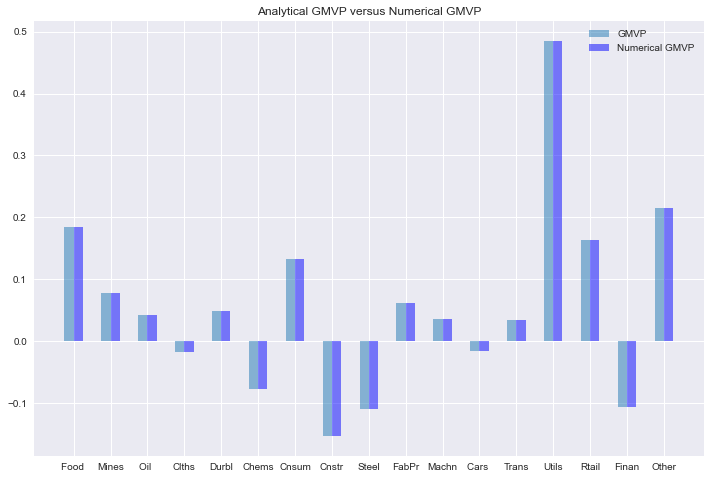

In [40]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVP.x, width=0.25, alpha=0.5, color='blue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP'])
plt.title('Analytical GMVP versus Numerical GMVP')


plt.show()

In [25]:
x0 = np.arange(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NMSRP = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons, options={'disp': True, 'ftol': 1e-9})

NMSRP.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25778589060143653
            Iterations: 32
            Function evaluations: 579
            Gradient evaluations: 32


array([ 0.32936398,  0.10543008,  0.03363064,  0.0948844 , -0.38315863,
       -0.09464698,  0.27273584,  0.00577303, -0.27845641,  0.11113565,
        0.2035534 ,  0.10909262,  0.02384575,  0.25633434,  0.20987346,
       -0.0727575 ,  0.07336633])

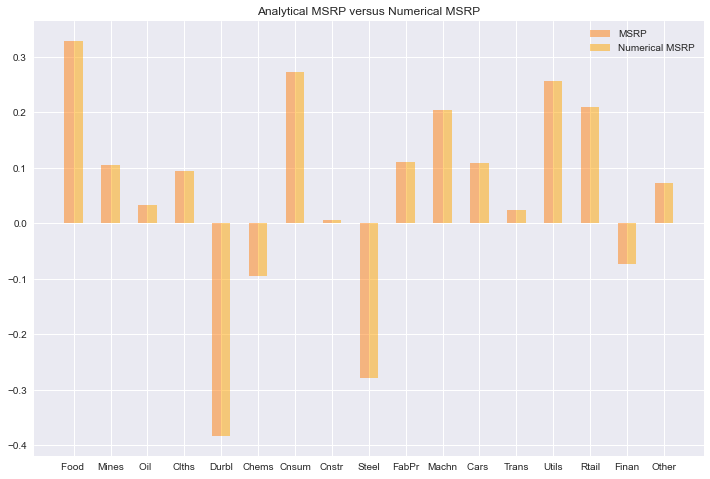

In [41]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRP.x, width=0.25, alpha=0.5, color='orange')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP'])
plt.title('Analytical MSRP versus Numerical MSRP')
plt.show()


### Numerical GMVP (No shortselling)

In [42]:
from scipy.optimize import Bounds

bounds = Bounds(0, 1) # 標的權重必須介於 0-1

x0 = GMVP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NGMVPnoSS = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)

NGMVPnoSS


Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.854969582863784
            Iterations: 11
            Function evaluations: 204
            Gradient evaluations: 11


     fun: 11.854969582863784
     jac: array([23.70994103, 23.70991898, 23.80013967, 25.87363076, 25.18939853,
       26.76456118, 23.70994151, 27.70517874, 28.99906838, 24.97839618,
       24.2929498 , 26.4506129 , 25.5953269 , 23.70994163, 23.70992935,
       27.07527363, 23.70993149])
 message: 'Optimization terminated successfully'
    nfev: 204
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.65891358e-01, 1.78253723e-02, 0.00000000e+00, 2.22941486e-15,
       5.44454356e-16, 1.70453543e-15, 1.64582010e-01, 7.00082916e-15,
       6.49580970e-15, 0.00000000e+00, 4.23479416e-16, 5.24881605e-15,
       0.00000000e+00, 5.00381601e-01, 8.17961938e-02, 5.01930549e-15,
       6.95234642e-02])

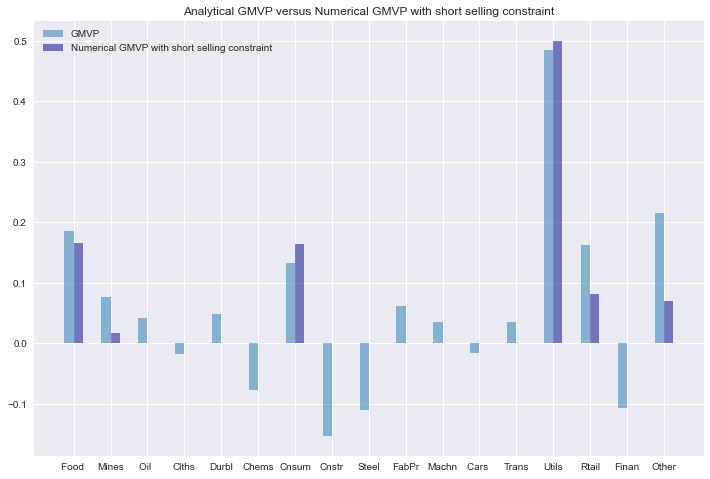

In [43]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))

plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVPnoSS.x, width=0.25, alpha=0.5, color='darkblue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP with short selling constraint'])
plt.title('Analytical GMVP versus Numerical GMVP with short selling constraint')
plt.show()

### Numerical MSRP (No shortselling)

In [45]:
from scipy.optimize import Bounds
bounds = Bounds(0, 1)
x0 = MSRP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NMSRPnoSS = minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22819911837659115
            Iterations: 15
            Function evaluations: 270
            Gradient evaluations: 15


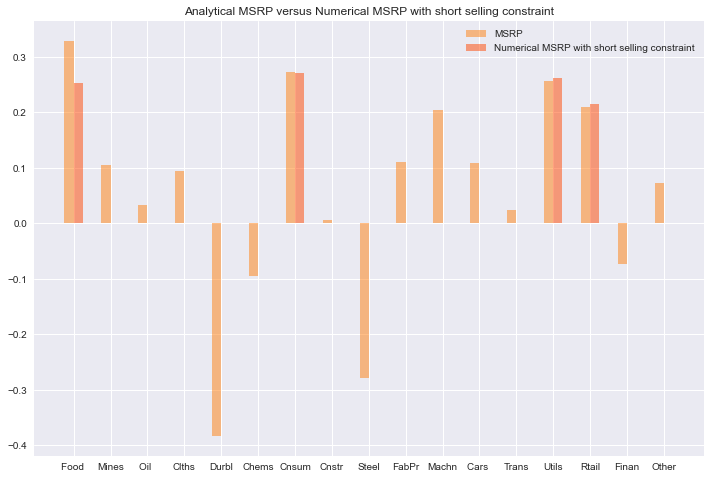

In [46]:
ind = np.arange(N)
plt.figure(figsize=(12, 8))

plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRPnoSS.x, width=0.25, alpha=0.5, color='orangered')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP with short selling constraint'])
plt.title('Analytical MSRP versus Numerical MSRP with short selling constraint')
plt.show()


## Step3: Visualization

In [47]:
df_ER.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10'],
            dtype='period[M]', name='Date', length=502)

In [57]:
Backtest_R.loc['1992-08', 'GMVP']

-1.4687387744759708

In [61]:
NMSRPnoSS.x

array([2.52267115e-01, 7.64531938e-18, 1.71490291e-17, 2.65087431e-17,
       0.00000000e+00, 0.00000000e+00, 2.70913135e-01, 0.00000000e+00,
       0.00000000e+00, 1.48391702e-17, 1.25250762e-17, 1.01389844e-17,
       0.00000000e+00, 2.62122020e-01, 2.14697731e-01, 4.49096869e-18,
       1.48484876e-18])

In [64]:
WSize = 60 # 以 60 個月 rolling
AvgER_rolling = df_ER.rolling(WSize).mean()
CovER_rolling = df_ER.rolling(WSize).cov()

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP', 'NGMVPnoSS', 'NMSRPnoSS', 'EW'])


for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    Backtest_R.loc[d,'GMVP'] = pret(gmvp(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(msrp(ER, S), R)
    Backtest_R.loc[d, 'NGMVPnoSS'] = pret(NGMVPnoSS.x, R)
    Backtest_R.loc[d, 'NMSRPnoSS'] = pret(NMSRPnoSS.x, R)

Backtest_R.loc[:,'EW'] = df_R.mean(axis=1) 
# 增加 equally weighted 的績效，recall df_R column 存放各產業的報酬

Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):] # delete NaN

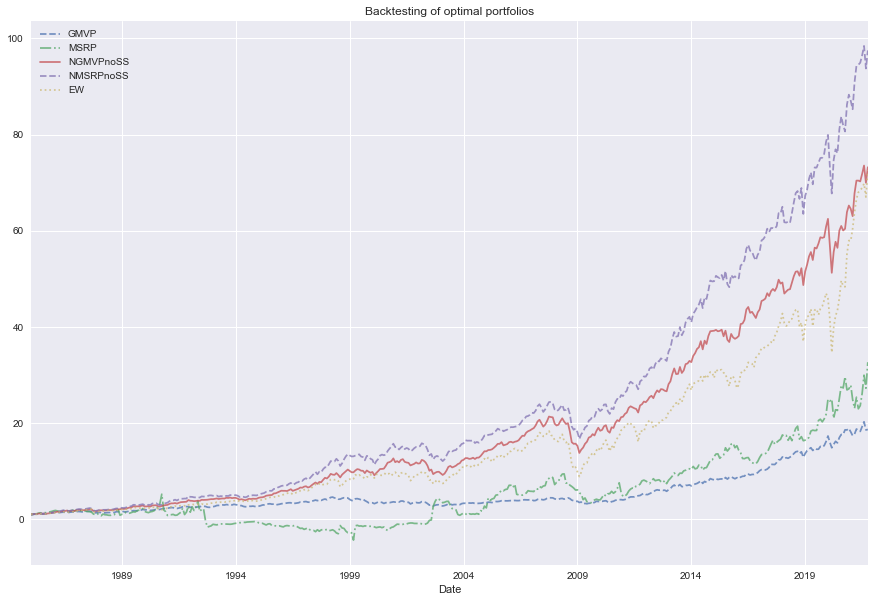

In [71]:
plt.style.use('seaborn')
plt.figure(figsize=(15, 10))

CumRet = (1 + Backtest_R.divide(100)).cumprod()

CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['NGMVPnoSS'].plot(alpha=0.75, linestyle="solid")
CumRet['NMSRPnoSS'].plot(alpha=0.75, linestyle="dashed")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()